In [ ]:
%cd ..

In [2]:
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as st
import torch
from torch.distributions import Normal
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from pathlib import Path
from tqdm import tqdm
from network import Decoder, Encoder
from config import MODELS_PATH, DATA_PATH, OUTPUT_PATH

In [3]:
encoder = Encoder()
decoder = Decoder()
encoder.load_state_dict(torch.load(Path(MODELS_PATH, "vae_encoder.pt")))
decoder.load_state_dict(torch.load(Path(MODELS_PATH, "vae_decoder.pt")))

data = MNIST(DATA_PATH, train=False, transform=ToTensor(), download=False)

# Distribution along embedding dimensions

In [4]:
all_means = []
all_log_vars = []

for x, y in tqdm(data):
    with torch.no_grad():
        mean, log_var = encoder(x.unsqueeze(0))
    all_means.append(mean.squeeze(0))
    all_log_vars.append(log_var.squeeze(0))

all_means = np.array(all_means)
all_log_vars = np.array(all_log_vars)

100%|██████████| 10000/10000 [00:03<00:00, 3006.65it/s]


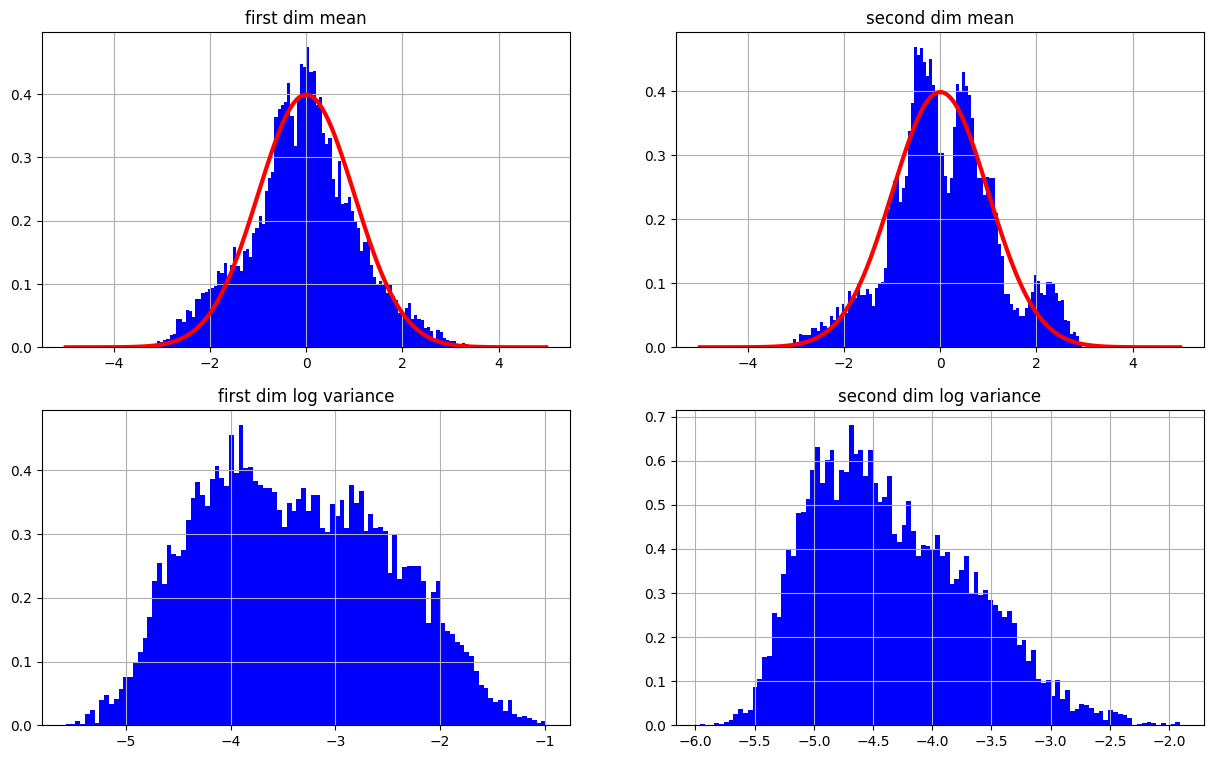

In [5]:
normal_x = np.arange(-5, 5, 0.01)
normal_y = st.norm.pdf(normal_x, loc=0, scale=1)
fig, ax = plt.subplots(2, 2, figsize=(15, 9))

ax[0, 0].hist(all_means[:, 0], bins=100, density=True, color="blue")
ax[0, 0].plot(normal_x, normal_y, color="red", linewidth=3)
ax[0, 0].grid(True)
ax[0, 0].set_title("first dim mean")

ax[0, 1].hist(all_means[:, 1], bins=100, density=True, color="blue")
ax[0, 1].plot(normal_x, normal_y, color="red", linewidth=3)
ax[0, 1].grid(True)
ax[0, 1].set_title("second dim mean")

ax[1, 0].hist(all_log_vars[:, 0], bins=100, density=True, color="blue")
ax[1, 0].grid(True)
ax[1, 0].set_title("first dim log variance")

ax[1, 1].hist(all_log_vars[:, 1], bins=100, density=True, color="blue")
ax[1, 1].grid(True)
ax[1, 1].set_title("second dim log variance")

plt.show()
fig.savefig(Path(OUTPUT_PATH, "embedding_distribution"))

# Example generation

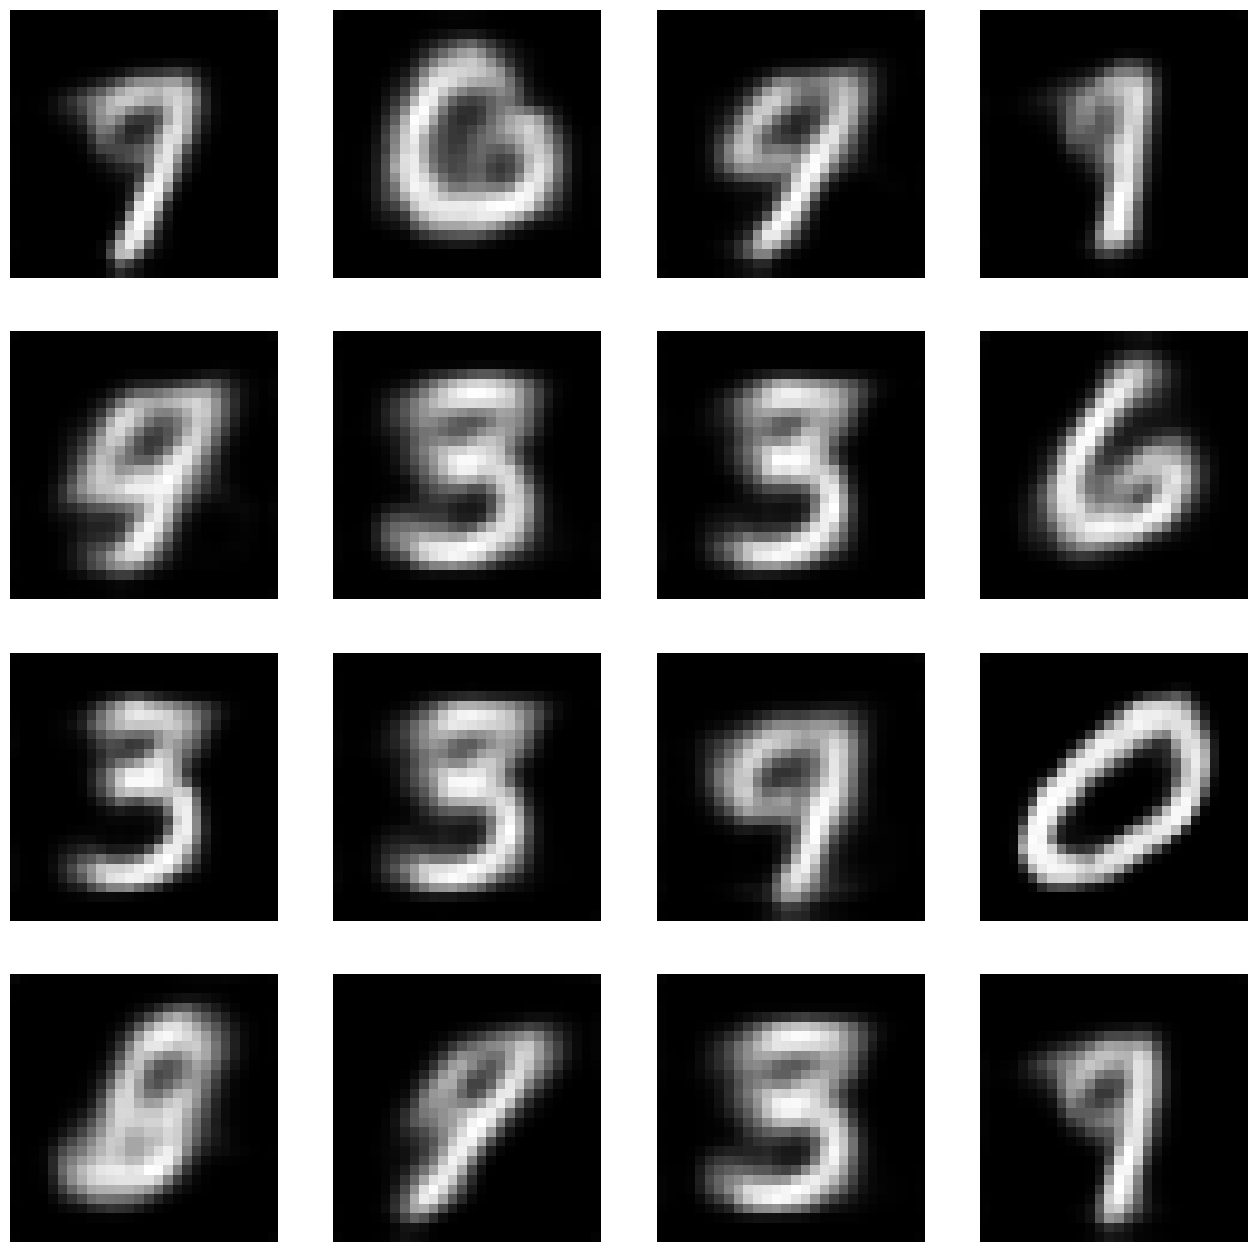

In [6]:
latent = Normal(0, 1).sample((16, 2))
with torch.no_grad():
    imgs = np.array(decoder(latent))

fig, ax = plt.subplots(4, 4, figsize=(16, 16))

for i in range(16):
    ax[i // 4, i % 4].imshow(imgs[i].squeeze(), cmap="gray")
    ax[i // 4, i % 4].axis("off")

plt.show()
fig.savefig(Path(OUTPUT_PATH, "example_generation"))

# Exploring latent space

In [7]:
classes = defaultdict(lambda: [])

for x, y in tqdm(data):
    with torch.no_grad():
        mean, log_var = np.array(encoder(x.unsqueeze(0))).squeeze()
    classes[y].append(mean)

for c in classes:
    classes[c] = np.array(classes[c])

100%|██████████| 10000/10000 [00:03<00:00, 3120.78it/s]


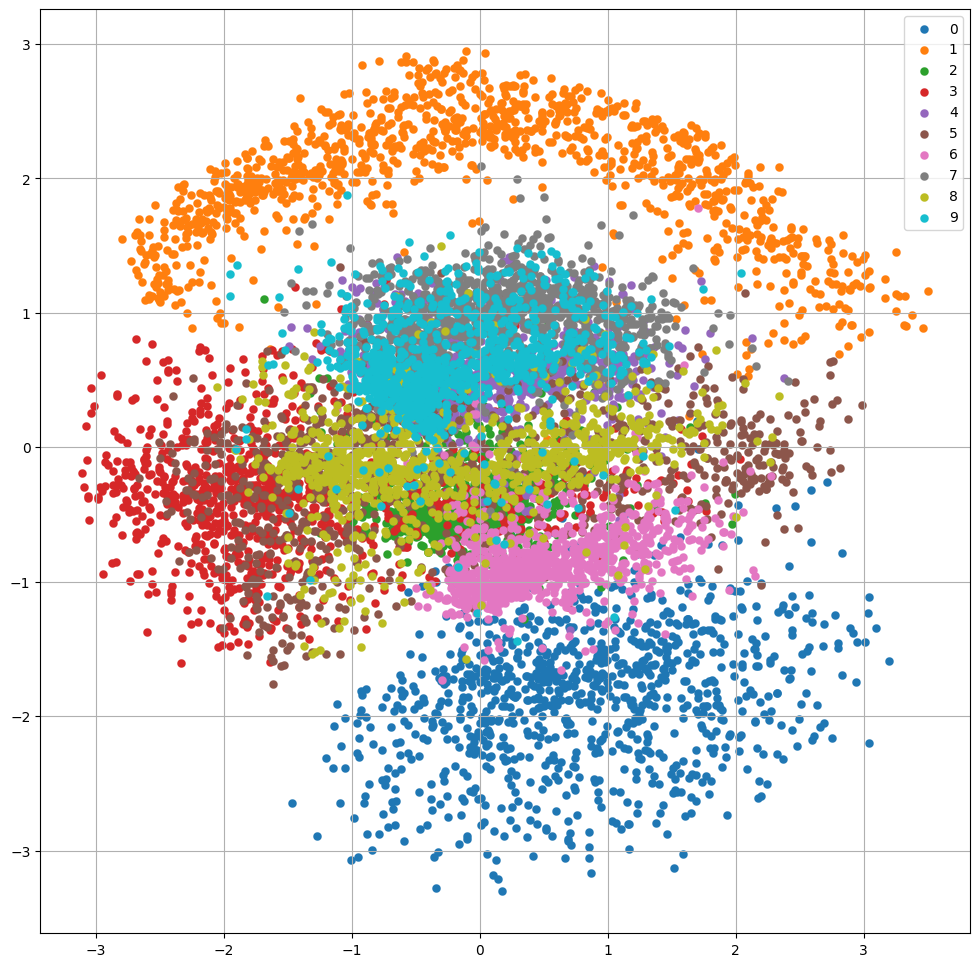

In [8]:
fig = plt.figure(figsize=(12, 12))
for label in range(10):
    plt.scatter(classes[label][:, 0], classes[label][:, 1], label=label, linewidths=0.1)

plt.legend()
plt.grid(True)
plt.show()
fig.savefig(Path(OUTPUT_PATH, "latent_space"))

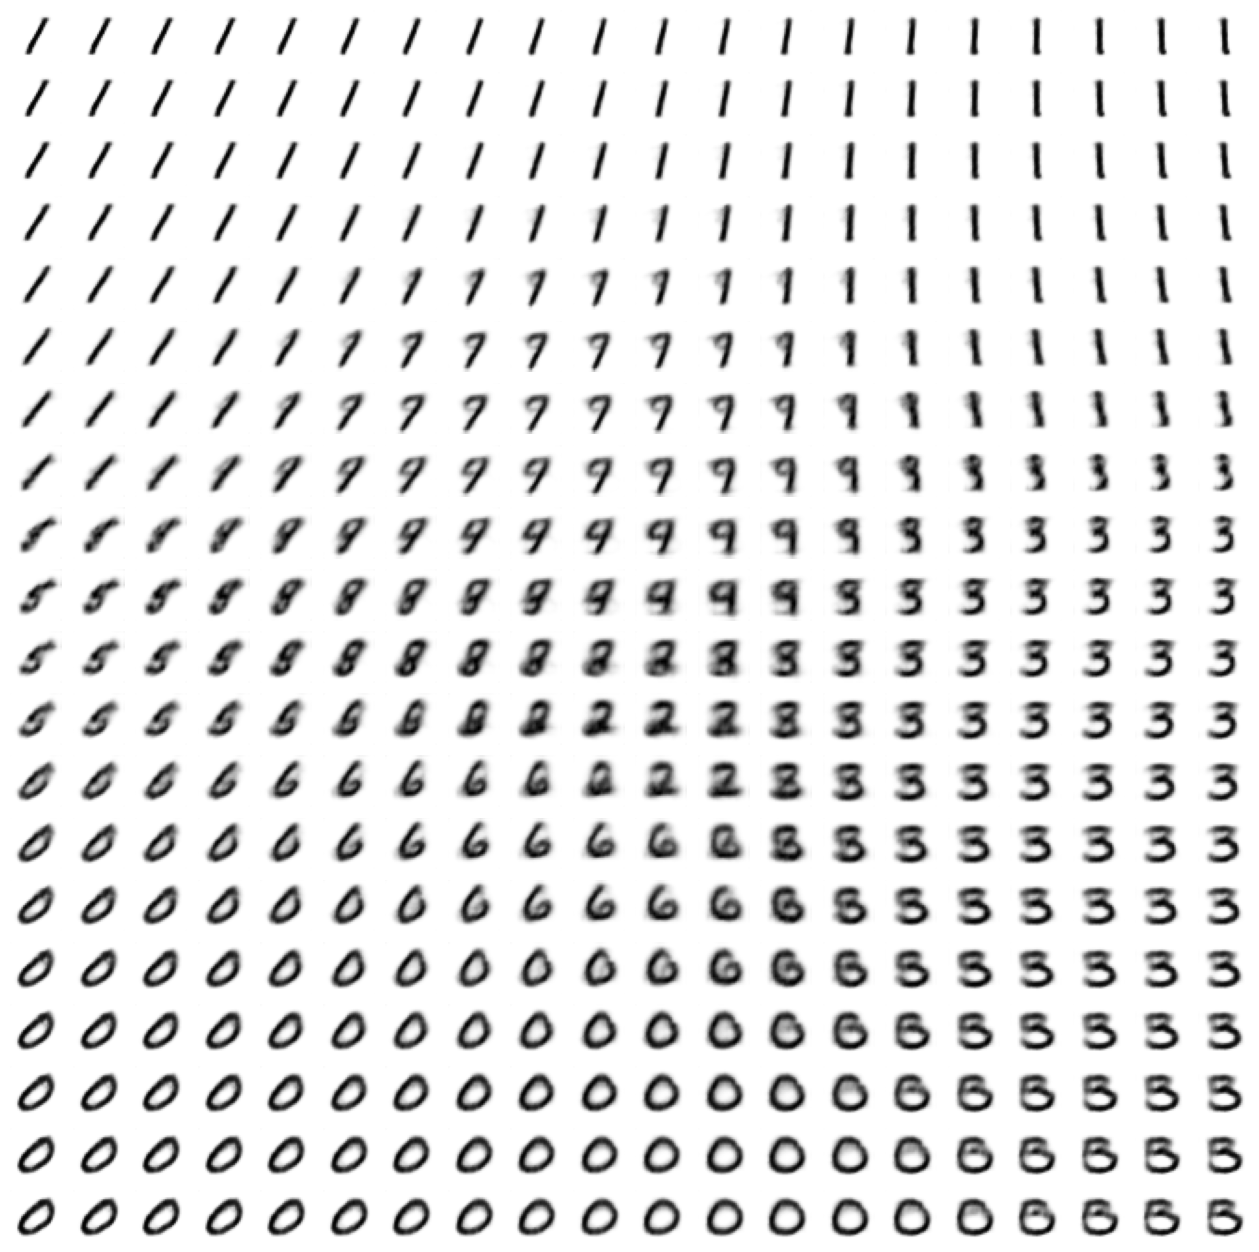

In [9]:
dim1 = np.linspace(2.5, -2.5, 20)
dim2 = np.linspace(2.5, -2.5, 20)
grid1, grid2 = np.meshgrid(dim1, dim2)

fig, ax = plt.subplots(20, 20, figsize=(16, 16))
for i in range(20):
    for j in range(20):
        latent = torch.tensor([[grid1[i, j], grid2[i, j]]], dtype=torch.float32)
        with torch.no_grad():
            img = 1 - np.array(decoder(latent)).squeeze()
            
        ax[i, j].imshow(img, cmap="gray")
        ax[i, j].axis("off")

plt.show() 
fig.savefig(Path(OUTPUT_PATH, "latent_space_generation"))